# Idea

Set up the data in matrix form as day/store for each family. Then use SVD as a preprocessing step to pool data across stores. The idea here is to use a low-rank approximation of the original data, which is likely to reduce the noise due to the fact that the most important eigenvalues from the SVD should be related to the actual signal in the data, so it is used as a sort of denoising technique.

In [1]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil, DATA_FOLDER
from storeSalesUtils.plotting import plot_joint_plot, plot_autocorrelations
from storeSalesUtils.prophetPipeline import (prophetPipeline, parse_holidays, parse_oil_prophet, median_filter,
                                      visualize_forecasts, RMSLE, grangers_causation_matrix)

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from numpy.linalg import svd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()
oil_prophet = parse_oil_prophet(oil)

test = load_test()

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', maxDate, minDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train.head()

Using data within the dates:  2017-08-15 00:00:00 2015-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,split
1700028,1700028,2015-08-15,1,AUTOMOTIVE,3.0,0,train
1700029,1700029,2015-08-15,1,BABY CARE,0.0,0,train
1700030,1700030,2015-08-15,1,BEAUTY,0.0,0,train
1700031,1700031,2015-08-15,1,BEVERAGES,2845.0,5,train
1700032,1700032,2015-08-15,1,BOOKS,0.0,0,train


In [3]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [94]:
family = 'AUTOMOTIVE'

train_dataMatrix = train[(train.split=='train') & (train.family==family)]

train_dataMatrix = train_dataMatrix.pivot_table(values='sales', index='date', columns='store_nbr')
train_dataMatrix.columns = train_dataMatrix.columns.astype(str)

# if all entries are zero, drop those stores
all_zeros_condition = (train_dataMatrix==0).sum() >= 0.9*len(train_dataMatrix)
all_zero_stores = all_zeros_condition[all_zeros_condition].index.tolist()
train_dataMatrix = train_dataMatrix.drop(all_zero_stores, axis=1)

# use rolling mean as target. Drop first rows which are NaN
window = 14
train_dataMatrix_smoothed = train_dataMatrix.rolling(window).mean()[window-1::]

train_dataMatrix_smoothed = train_dataMatrix_smoothed[['1', '2', '3']]

print(train_dataMatrix_smoothed.shape)
train_dataMatrix_smoothed.head()

(701, 3)


store_nbr,1,2,3
date,,,
2015-08-28,2.642857,6.214286,9.071429
2015-08-29,2.785714,6.857143,8.428571
2015-08-30,2.785714,6.500000,8.500000
2015-08-31,3.214286,6.500000,8.714286
2015-09-01,2.571429,6.642857,8.571429


<AxesSubplot: xlabel='date'>

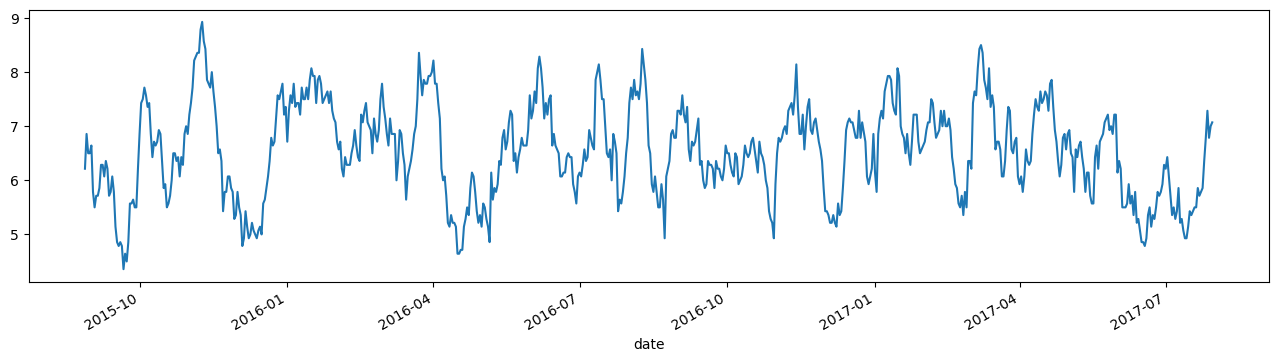

In [95]:
train_dataMatrix_smoothed['2'].plot()

In [96]:
u, s, vh = svd(train_dataMatrix_smoothed, full_matrices=True)
u.shape, s.shape, vh.shape

((701, 701), (3,), (3, 3))

In [97]:
u[:, :10].shape

(701, 10)

In [100]:
lowRank_components = np.where(cumulative_comps>thresh)[0][0]
train_lowRank = np.dot(u[:, :lowRank_components] * s[:lowRank_components], vh[:lowRank_components, :])
np.dot(u[:, :lowRank_components] * s[:lowRank_components], vh[:lowRank_components, :])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [101]:
np.where(cumulative_comps>thresh)[0][0]

0

In [130]:
cumulative_comps = s.cumsum()/s.sum()

# select the number of components which account for some threshold of the cumulative singular values
thresh = 0.8
lowRank_components = np.where(cumulative_comps>thresh)[0][0]+1
train_lowRank = np.dot(u[:, :lowRank_components] * s[:lowRank_components], vh[:lowRank_components, :])

train_lowRank = pd.DataFrame(train_lowRank, index=train_dataMatrix_smoothed.index, columns=train_dataMatrix_smoothed.columns)

# standardize data
store_lowRank_means = train_lowRank.mean()
store_lowRank_stds = train_lowRank.std()
train_lowRank = (train_lowRank - store_lowRank_means)/store_lowRank_stds

# we want to ignore streaks of consecutive zeros, so we set this to NaN
aux = pd.DataFrame(np.where(train_dataMatrix_smoothed.rolling(7).mean() == 0, np.nan, 1),
                   index=train_lowRank.index, columns=train_lowRank.columns)
train_lowRank = train_lowRank * aux

# for holt_winters model
# train_lowRank = train_lowRank.apply(lambda x: x.fillna(x.mean()), axis=0)

# # ignore extreme values:
# for col in train_lowRank.columns:
#     train_lowRank[col] = median_filter(train_lowRank, col, window=28, std=3)

train_lowRank['total'] = train_lowRank.sum(axis=1)
train_lowRank.head()

store_nbr,1,2,3,total
date,,,,
2015-08-28,-1.567459,-1.567459,-1.567459,-4.702377
2015-08-29,-1.686189,-1.686189,-1.686189,-5.058566
2015-08-30,-1.758255,-1.758255,-1.758255,-5.274765
2015-08-31,-1.559839,-1.559839,-1.559839,-4.679518
2015-09-01,-1.717380,-1.717380,-1.717380,-5.152139


In [131]:
from hts import HTSRegressor

In [132]:
stores = train_lowRank.drop('total', axis=1).columns.to_list()

hierarchy = {
    'total': stores,
}
stores_dict = dict(zip(stores, [[s] for s in stores]))

hierarchy = {**hierarchy}
# hierarchy

In [142]:
reg = HTSRegressor(model='prophet', revision_method='OLS', **{'yearly_seasonality':True, 'weekly_seasonality':True})
reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

Fitting models:  25%|██████▎                  | 1/4 [00:00<00:02,  1.01it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models: 100%|█████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


In [143]:
# reg = HTSRegressor(model='holt_winters', revision_method='OLS', **{'seasonal_periods':7})
# reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

In [144]:
# reg = HTSRegressor(model='auto_arima', revision_method='OLS',
#                    **{
#                        'm':7, 'seasonal':True, 'start_p':0,
#                        'start_q':0, 'max_p':2, 'max_q':2
#                    })

# reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

In [145]:
preds = reg.predict(steps_ahead=16)

Fitting models: 100%|█████████████████████████| 4/4 [00:12<00:00,  3.09s/it]


<AxesSubplot: xlabel='date'>

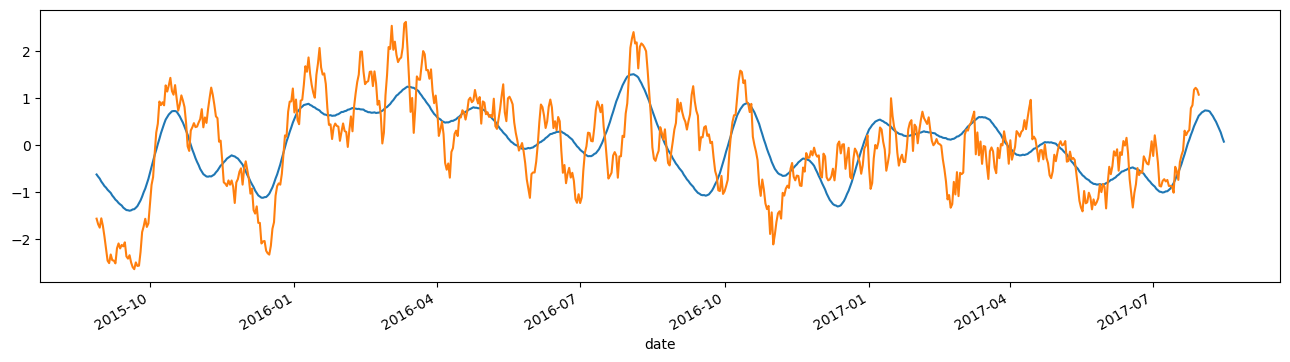

In [146]:
preds['1'].plot()
train_lowRank['1'].plot()
# train_dataMatrix['1'].plot()

In [147]:
# maybe use last 15 days to compute the means
prev_15 = train_dataMatrix_smoothed[train_dataMatrix_smoothed.index >= pd.to_datetime('2017-07-14')]

# go back to actual scale of values
adjusted_preds = (preds.drop('total', axis=1)*train_dataMatrix_smoothed.std())+train_dataMatrix_smoothed.mean()
# adjusted_preds = (preds.drop('total', axis=1)*prev_15.std())+prev_15.mean()

for col in all_zero_stores:
    adjusted_preds[col] = 0

# we want only non-negative predictions
adjusted_preds = adjusted_preds.where(adjusted_preds>=0, 0)

adjusted_preds.describe()

,1,2,3
count,717.000000,717.000000,717.000000
mean,4.105296,6.550915,11.298862
std,0.564295,0.575628,1.027359
min,2.916755,5.336409,9.136963
25%,3.629479,6.066690,10.432760
50%,4.153139,6.598239,11.385378
75%,4.573544,7.030385,12.149675
max,5.363770,7.833952,13.590449


<AxesSubplot: xlabel='date'>

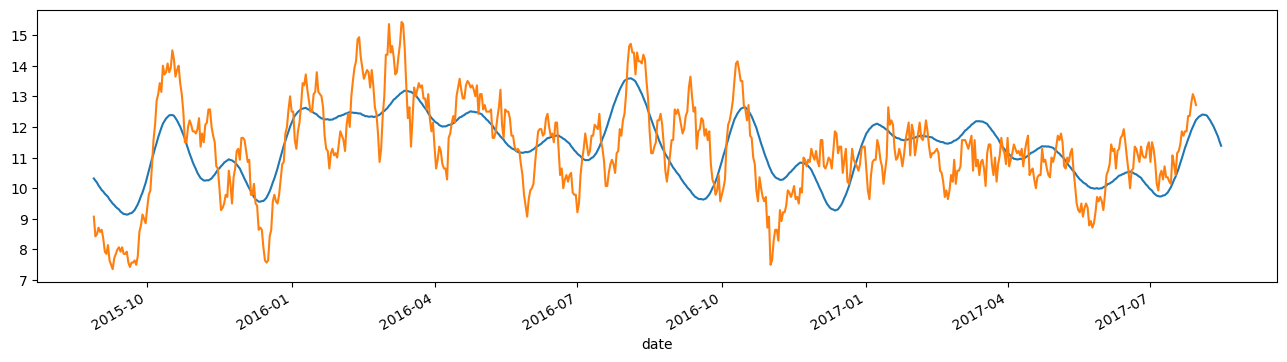

In [148]:
adjusted_preds['3'].plot()
train_dataMatrix_smoothed['3'].plot()
# train_dataMatrix['1'].plot()

In [149]:
validation_dataMatrix = train[(train.split=='validation') & (train.family==family)]

validation_dataMatrix = validation_dataMatrix.pivot_table(values='sales', index='date', columns='store_nbr')
validation_dataMatrix.columns = validation_dataMatrix.columns.astype(str)

print(validation_dataMatrix.shape)

val_assessment = adjusted_preds.loc[validation_dataMatrix.index.min():validation_dataMatrix.index.max(), :]

val_assessment = val_assessment.melt(ignore_index=False).reset_index()
val_assessment.columns = ['date', 'store_nbr', 'pred']
val_assessment['store_nbr'] = val_assessment.store_nbr.astype(int)

aux = train[(train.split=='validation') & (train.family==family)][['date', 'store_nbr', 'sales']]

val_assessment = val_assessment.merge(aux, on=['date', 'store_nbr'])
val_assessment['abs_err'] = abs(val_assessment.pred - val_assessment.sales)

RMSLE(val_assessment.pred, val_assessment.sales)

(16, 54)


0.569

<AxesSubplot: >

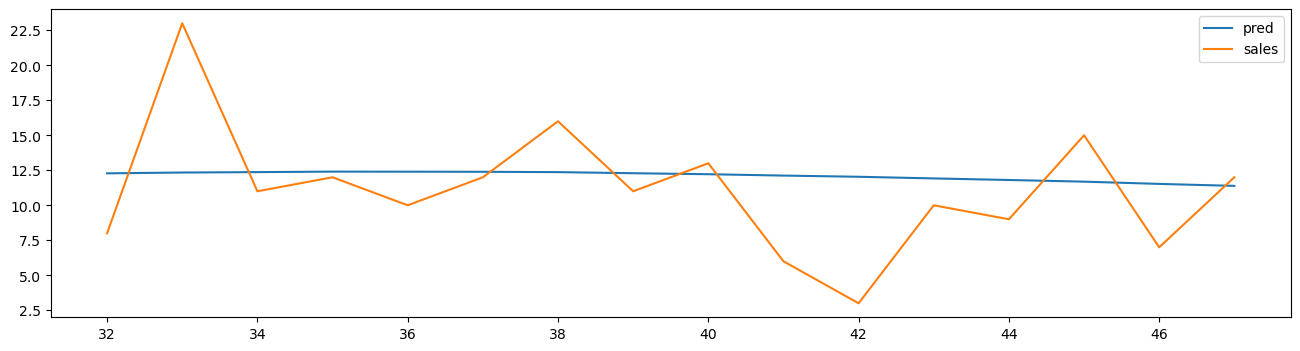

In [152]:
val_assessment.loc[val_assessment.store_nbr==3, ['pred', 'sales']].plot()

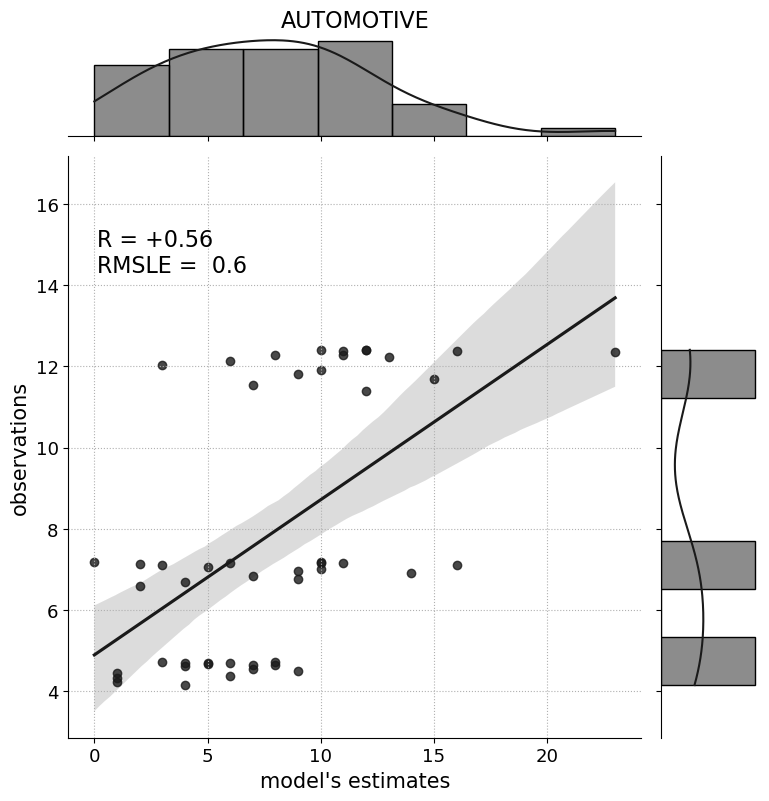

In [151]:
p = plot_joint_plot(val_assessment, x='sales', y='pred', title=family)
# p.savefig('myfig.png')

In [110]:
error_df = val_assessment.groupby('store_nbr').abs_err.mean().sort_values(ascending=False)

worst_preds = error_df[0:5]
worst_preds

store_nbr
52    6.000000
9     5.967378
47    5.939930
53    5.183155
46    5.062785
Name: abs_err, dtype: float64

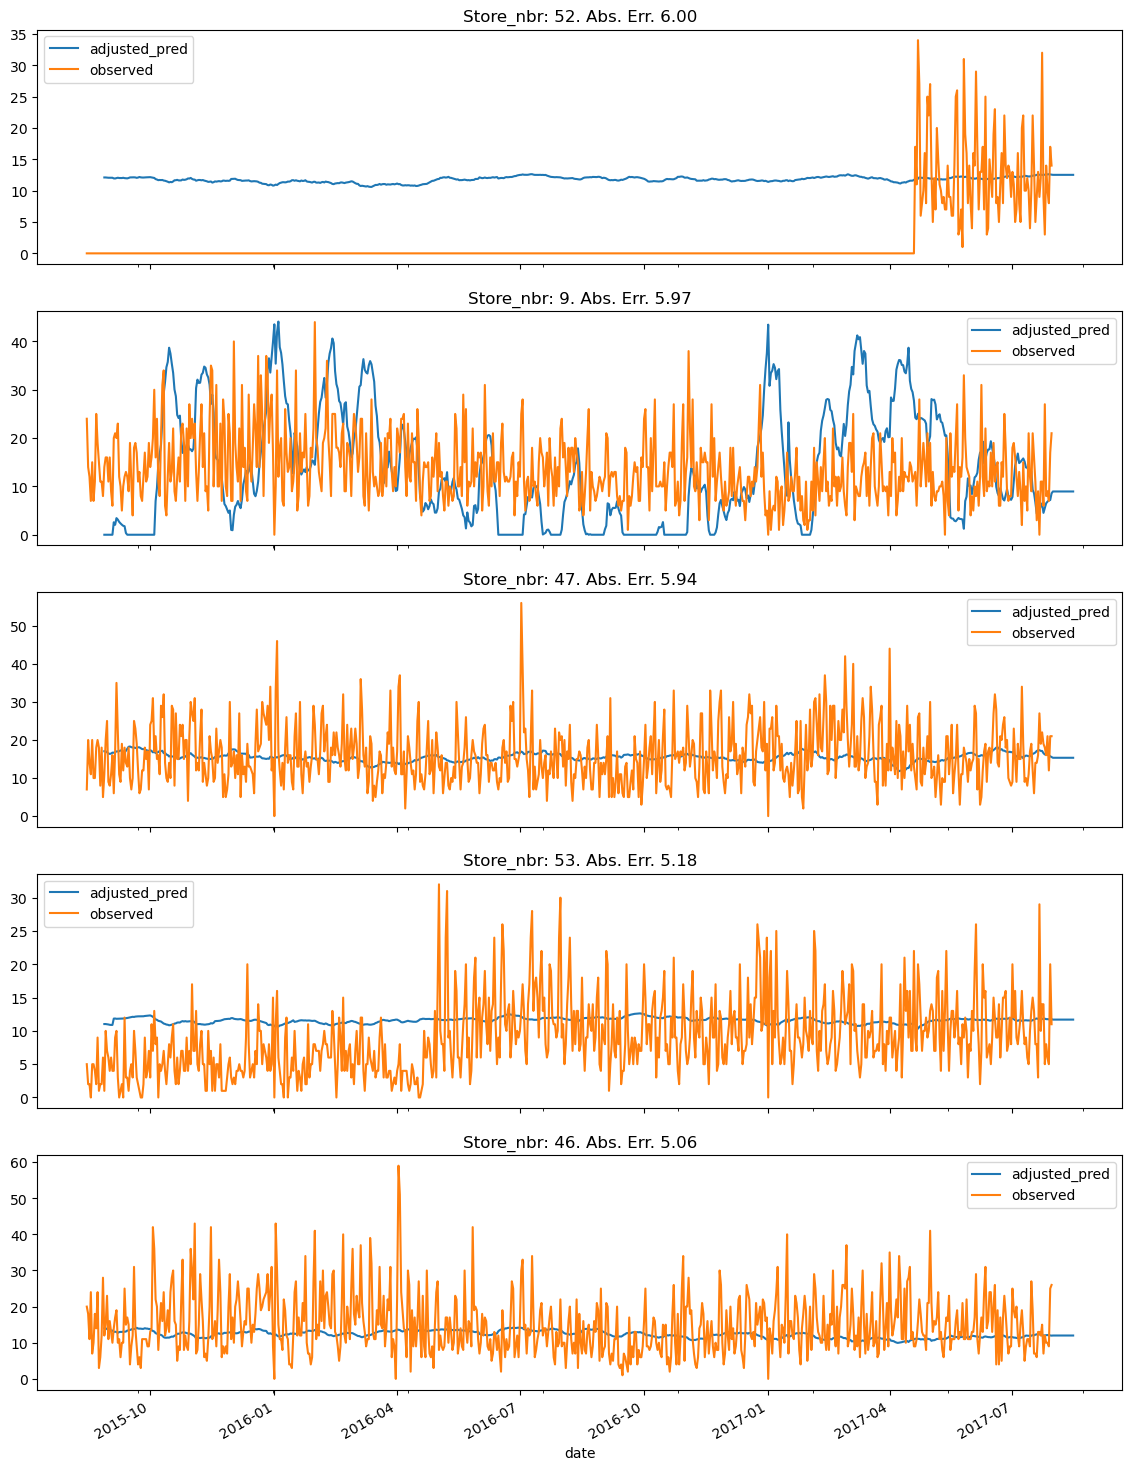

In [111]:
# np.random.seed(2)
# sample = np.random.randint(0, len(train_lowRank.columns), 10)
# sample = [str(col) for col in sample]

fig, ax = plt.subplots(len(worst_preds), 1, sharex=True, figsize=(14, 4*len(worst_preds)))

for i, store_nbr in enumerate(worst_preds.index.values):
    store_nbr_str = str(store_nbr)
    store_error = worst_preds[worst_preds.index==store_nbr]
    adjusted_preds[store_nbr_str].plot(legend='adjusted_pred', label='adjusted_pred', ax=ax[i])
    # preds[col].plot(legend='pred', label='pred', ax=ax[i])
    train_dataMatrix[store_nbr_str].plot(legend='observed', label='observed', ax=ax[i])
    # train_lowRank[store_nbr_str].plot(legend='lowRank', label='lowRank', ax=ax[i])
    ax[i].set_title('Store_nbr: %s. Abs. Err. %.02f' %(store_nbr_str, store_error))
    
# plt.savefig()
plt.show()

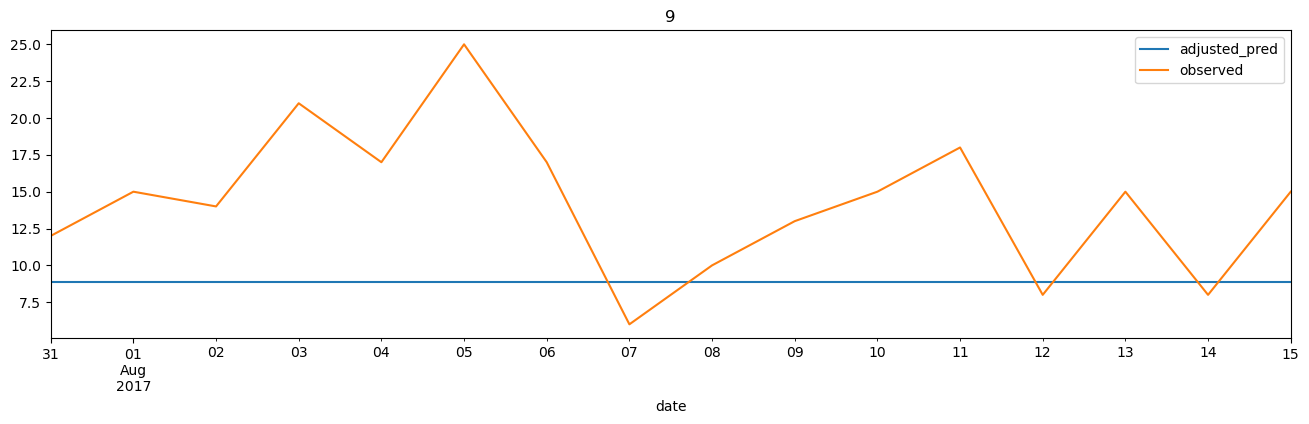

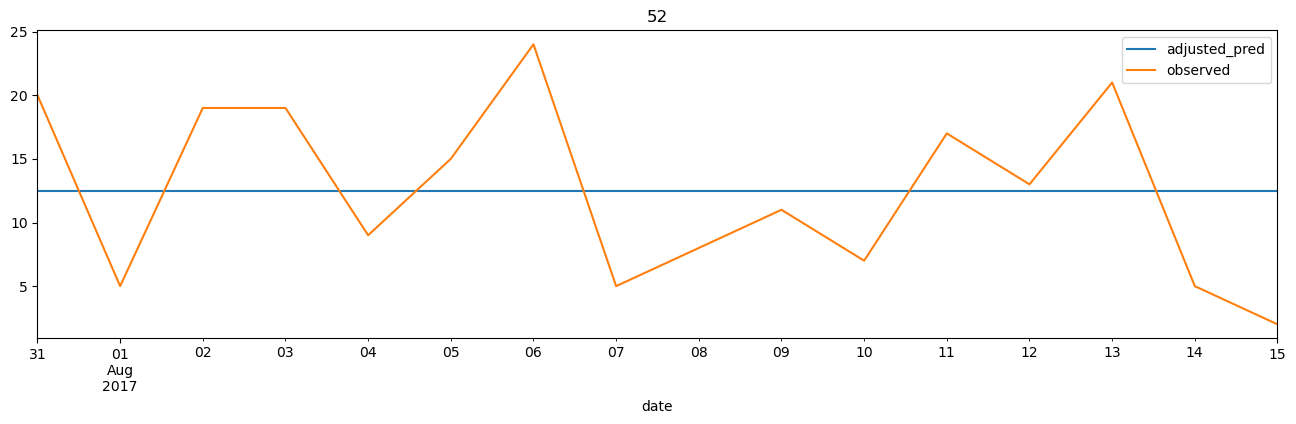

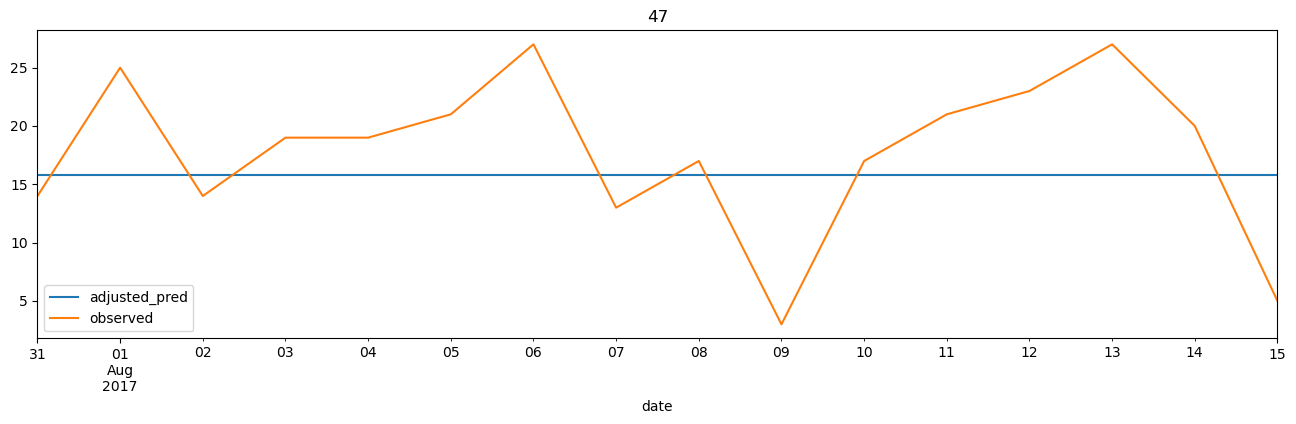

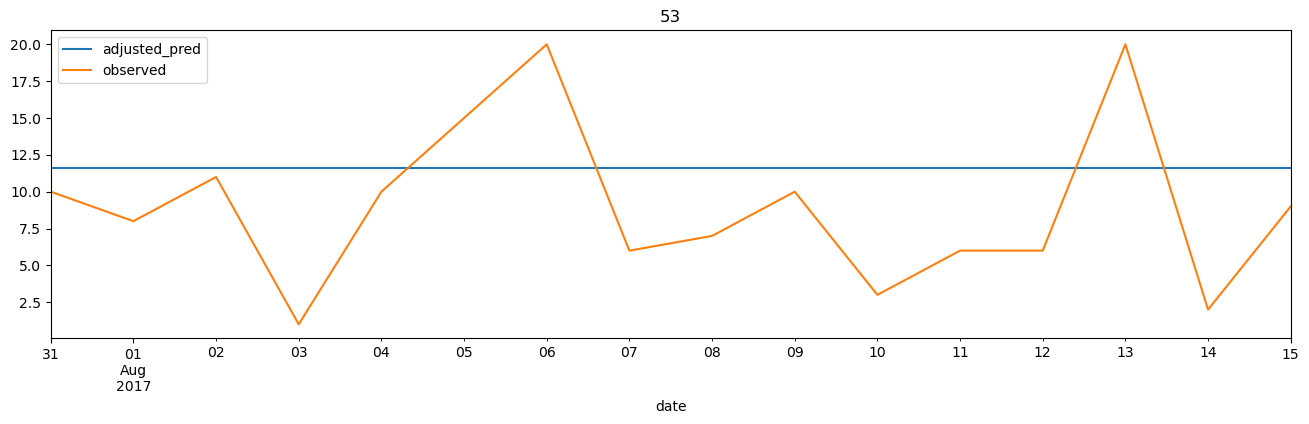

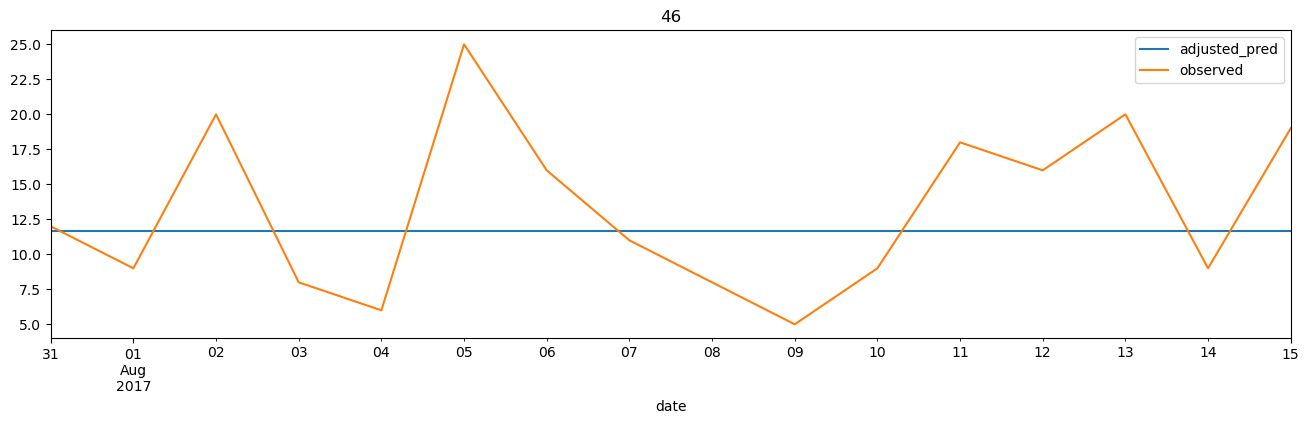

In [60]:
for store_nbr in worst_preds.index.values:
    
    ax = adjusted_preds.loc[validation_dataMatrix.index.min():validation_dataMatrix.index.max(), str(store_nbr)
                           ].plot(legend='adjusted_pred', label='adjusted_pred')
    validation_dataMatrix[str(store_nbr)].plot(ax=ax, legend='observed', label='observed')
    ax.set_title(str(store_nbr))
    plt.show()

In [65]:
import pandas as pd
import numpy as np
from hts import HTSRegressor

days = pd.date_range(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-12-31'), freq='W')

df = pd.DataFrame(np.random.randint(0,100,size=(len(days),12)), columns=['a_x_1', 'a_x_2',
                                                                    'a_y_1', 'a_y_2',
                                                                    'b_x_1', 'b_x_2',
                                                                    'b_y_1', 'b_y_2',
                                                                    'c_x_1', 'c_x_2',
                                                                    'c_y_1', 'c_y_2'])
df['a_x'] = df['a_x_1'] + df['a_x_2']
df['a_y'] = df['a_y_1'] + df['a_y_2']
df['b_x'] = df['b_x_1'] + df['b_x_2']
df['b_y'] = df['b_y_1'] + df['b_y_2']
df['c_x'] = df['c_x_1'] + df['c_x_2']
df['c_y'] = df['c_y_1'] + df['c_y_2']
df['a'] = df['a_x'] + df['a_y']
df['b'] = df['b_x'] + df['b_y']
df['c'] = df['c_x'] + df['c_y']
df['total'] = df['a'] + df['b'] + df['c']
df['date'] = days
df = df.set_index('date')

hier = {'total': ['a', 'b', 'c'],
            'a': ['a_x', 'a_y'],
            'b': ['b_x', 'b_y'],
            'c': ['c_x', 'c_y'],
            'a_x': ['a_x_1', 'a_x_2'],
            'a_y': ['a_y_1', 'a_y_2'],
            'b_x': ['b_x_1', 'b_x_2'],
            'b_y': ['b_y_1', 'b_y_2'],
            'c_x': ['c_x_1', 'c_x_2'],
            'c_y': ['c_y_1', 'c_y_2']
        }

In [69]:
model_bu_prophet = HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
model_bu_prophet = model_bu_prophet.fit(df, hier, show_warnings=False)
pred_bu_prophet = model_bu_prophet.predict(steps_ahead=52)

Fitting models:   0%|                                | 0/22 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   9%|██▏                     | 2/22 [00:00<00:01, 16.89it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling

<AxesSubplot: xlabel='date'>

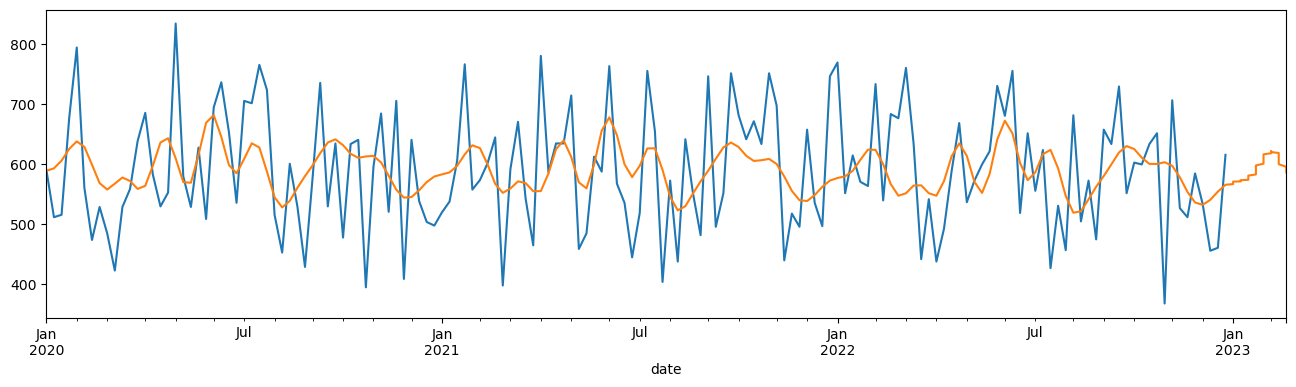

In [70]:
col = 'total'
ax = df[col].plot()
pred_bu_prophet[col].plot(ax=ax)

<AxesSubplot: xlabel='date'>

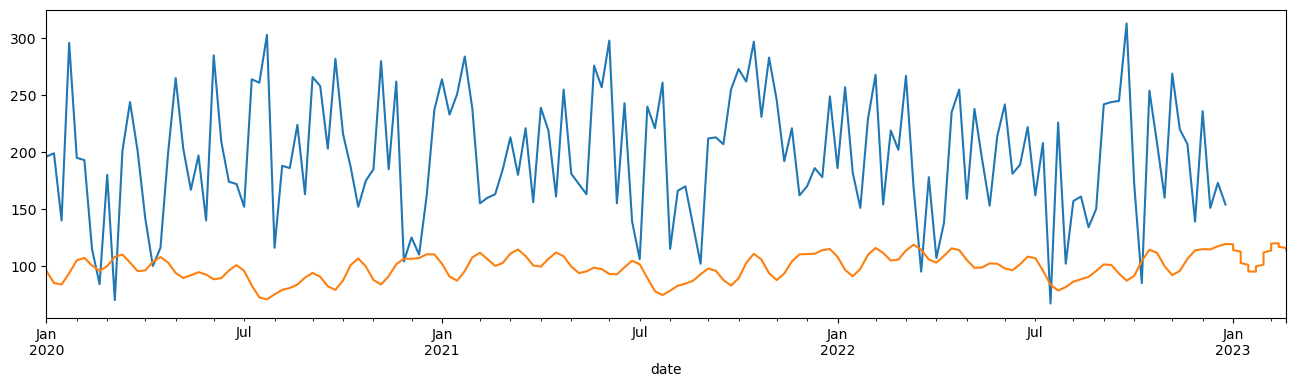

In [71]:
col = 'a'
ax = df[col].plot()
pred_bu_prophet[col].plot(ax=ax)

In [72]:
pred_bu_prophet

,total,a,b,c,a_x,a_y,b_x,b_y,c_x,c_y,...,a_y_1,a_y_2,b_x_1,b_x_2,b_y_1,b_y_2,c_x_1,c_x_2,c_y_1,c_y_2
2020-01-05,588.313470,95.791841,86.953302,88.076737,99.686782,110.926551,106.878257,182.745143,187.763519,217.804808,...,63.853822,47.072729,47.019076,52.667706,43.152425,44.924311,46.893035,40.060267,51.066984,44.724858
2020-01-12,592.508040,85.074819,86.684768,80.690896,119.806561,121.718109,98.532887,171.759587,200.497457,220.250996,...,60.635281,61.082828,63.130141,56.676420,46.479681,34.211214,48.799222,37.885546,40.532025,44.542794
2020-01-19,605.272219,83.706012,92.943641,82.091386,124.392324,121.231360,100.907495,176.649653,206.483710,222.138855,...,54.738325,66.493035,70.287787,54.104537,45.929598,36.161789,47.625434,45.318207,35.016500,48.689512
2020-01-26,624.827575,93.627833,106.592161,94.450412,108.135655,110.908777,111.112736,200.219994,202.586068,222.021513,...,46.982284,63.926493,61.475465,46.660190,42.357732,52.092680,46.932778,59.659383,40.724666,52.903167
2020-02-02,637.407710,104.966107,120.267398,110.443408,88.291974,95.517204,117.921619,225.233505,198.735382,213.438824,...,36.992555,58.524649,47.558489,40.733484,40.310271,70.133137,50.158904,70.108494,52.627586,52.338521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11,603.551656,117.773832,124.244755,111.114182,68.477972,82.205005,99.735910,242.018587,179.592154,181.940915,...,22.238897,59.966109,37.594032,30.883939,40.108923,71.005260,60.717189,63.527566,77.409304,40.364528
2023-02-12,599.394134,116.838556,122.952645,110.040639,71.061054,80.399372,98.101868,239.791201,181.101694,178.501240,...,21.884028,58.515344,38.658911,32.402143,40.370755,69.669885,61.190385,61.762260,77.352812,39.485744
2023-02-13,594.941697,115.806677,121.436523,108.669178,73.906553,78.707537,96.415227,237.243201,182.575731,175.122765,...,21.733476,56.974061,39.841898,34.064655,40.605769,68.063410,61.553969,59.882554,77.128729,38.677948
2023-02-14,590.260982,114.715020,119.726765,107.029183,76.937195,77.142334,94.710484,234.441785,183.966378,171.852818,...,21.794816,55.347518,41.088820,35.848375,40.805869,66.223314,61.799264,57.927501,76.753835,37.961184
